In [1]:
import csv

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import pandas as pd

In [2]:
# filename_Q = "../calibration-data/WS_Q_120-04-09_15-51-01.csv"
# filename_DP = "../calibration-data/WS_DP_sensor3_1.csv"
filename_Q = "/home/pivarski/Downloads/Sensirion_Q_1.csv"
filename_DP = "/home/pivarski/Downloads/Sensirion_DP_sensor3_1.csv"
filename_sanity = "../sanity-plot.png"
filename_calplot = "../calibration-plot.png"
filename_out = "../matched-points.csv"

In [3]:
df_Q = pd.read_csv(filename_Q)
df_Q["Time"] = pd.to_datetime(df_Q["Time"])
df_Q

,Device,Pressure,Temperature,Volumetric Flow,Mass Flow,Set Point,Total,Gas,Date,Time,Elaps. Mill.
0,B,14.33,24.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:48:51.867,75.9860
1,B,14.33,24.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:48:51.977,183.4335
2,B,14.33,24.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:48:52.086,292.8357
3,B,14.33,24.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:48:52.195,402.1892
4,B,14.33,24.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:48:52.305,511.3163
...,...,...,...,...,...,...,...,...,...,...,...
1846,B,14.33,23.40,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:52:16.244,204450.7901
1847,B,14.33,23.40,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:52:16.353,204559.9193
1848,B,14.33,23.41,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:52:16.463,204669.6438
1849,B,14.33,23.41,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 19:52:16.572,204779.4266


In [4]:
def read_data(filename):
    t = []
    dp = []
    with open(filename) as file:
        start_fill = False
        for line in csv.reader(file):
            if start_fill:
                t.append(float(line[1].replace(",", "")))
                dp.append(float(line[2]))
            if line[0] == "Sample #":
                start_fill = True
    return pd.DataFrame({"Time": np.array(t), "Delta Pressure": np.array(dp)})

df_DP = read_data(filename_DP)
df_DP

,Time,Delta Pressure
0,202.0689,0.033
1,202.0741,0.000
2,202.0793,0.017
3,202.0834,0.000
4,202.0874,-0.017
...,...,...
43730,420.6056,0.000
43731,420.6088,0.017
43732,420.6141,0.000
43733,420.6194,0.000


In [10]:
df_Q["Volumetric Flow"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1846    0.0
1847    0.0
1848    0.0
1849    0.0
1850    0.0
Name: Volumetric Flow, Length: 1851, dtype: float64

In [19]:
comparator = df_Q["Volumetric Flow"].rolling(5).mean().fillna(method="bfill").values**(7/4)
delta = abs(comparator[1:] - comparator[:-1])
origin_Q = df_Q["Time"].values[np.argmax(delta)]
df_Q["Common Time"] = (df_Q["Time"] - origin_Q).dt.total_seconds()
df_Q["Binned Time"] = (10*df_Q["Common Time"].values).astype(np.int64)

with np.errstate(divide="ignore", invalid="ignore"):
    changes, = np.nonzero(np.logical_and(delta > 1.0, delta/comparator[:-1] > 0.05))
change_times = df_Q["Common Time"].values[changes]

df_Q["Common Time"]

0      -175.718
1      -175.608
2      -175.499
3      -175.390
4      -175.280
         ...   
1846     28.659
1847     28.768
1848     28.878
1849     28.987
1850     29.096
Name: Common Time, Length: 1851, dtype: float64

In [20]:
comparator = df_DP["Delta Pressure"].rolling(5).mean().fillna(method="bfill").values
delta = abs(comparator[1:] - comparator[:-1])
origin_DP = df_DP["Time"].values[np.argmax(delta)]
df_DP["Common Time"] = df_DP["Time"] - origin_DP
df_DP["Binned Time"] = (10*df_DP["Common Time"].values).astype(np.int64)
df_DP["Common Time"]

0       -186.7603
1       -186.7551
2       -186.7499
3       -186.7458
4       -186.7418
           ...   
43730     31.7764
43731     31.7796
43732     31.7849
43733     31.7902
43734     31.7955
Name: Common Time, Length: 43735, dtype: float64

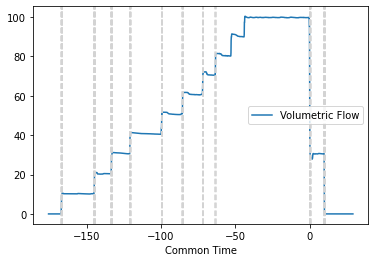

In [21]:
ax = df_Q.plot("Common Time", "Volumetric Flow")
for t in change_times:
    ax.axvline(t, c="lightgray", ls="--")

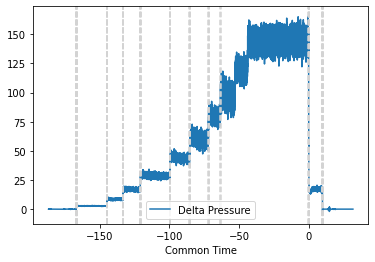

In [22]:
ax = df_DP.plot("Common Time", "Delta Pressure")
for t in change_times:
    ax.axvline(t, c="lightgray", ls="--")

In [ ]:
binned_Q = df_Q[["Common Time", "Binned Time", "Volumetric Flow"]].groupby("Binned Time").mean()
binned_Q.plot("Common Time", "Volumetric Flow")
binned_Q

In [ ]:
binned_DP = df_DP[["Common Time", "Binned Time", "Delta Pressure"]].groupby("Binned Time").mean()
binned_DP.plot("Common Time", "Delta Pressure")
binned_DP

In [ ]:
df = pd.merge(binned_Q, binned_DP, how="inner", on="Binned Time")
df

In [ ]:
ax = df.plot("Common Time_x", ["Volumetric Flow", "Delta Pressure"])
for t in change_times:
    ax.axvline(t, c="lightgray", ls="--")
ax.figure.savefig(filename_sanity)

In [ ]:
since_change = df["Common Time_x"].values[:, np.newaxis] - change_times[np.newaxis, :]
df["Recent Change"] = np.any((-2 <= since_change) & (since_change < 8), axis=1)
since_change[since_change < 0] = np.inf
df["Since Change"] = np.min(since_change, axis=1)
df

In [ ]:
df[~df["Recent Change"]].plot.scatter("Common Time_x", "Volumetric Flow")

In [ ]:
df[~df["Recent Change"]].plot.scatter("Common Time_x", "Delta Pressure")

In [ ]:
df[~df["Recent Change"]].plot.scatter("Volumetric Flow", "Delta Pressure")

In [ ]:
xs = df[~df["Recent Change"]]["Volumetric Flow"].values
ys = df[~df["Recent Change"]]["Delta Pressure"].values

def fit(x, constant):
    return np.sign(x)*(constant * abs(x)**(7.0/4.0))

(fit_constant,), covariance = scipy.optimize.curve_fit(fit, xs, ys)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
curve_xs = np.linspace(-35, 1000, 1000)

for ax in (ax1, ax2, ax3):
    h2, = ax.plot(curve_xs, fit(curve_xs, fit_constant), label="DP = {:.4f}*Q**7/4".format(fit_constant))
    h0, = ax.plot(xs, ys, "o", c="red", label="measurements")
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 150)
    ax.set_xlabel("flow Q (L/min)")
    ax.set_ylabel("delta pressure DP (Pa)")
    ax.legend(handles=[h0, h2])

ax2.axvline(0, c="gray")
ax2.axhline(0, c="gray")
ax2.set_xlim(-35, 35)
ax2.set_ylim(-35, 35)

ax3.set_xlim(1, 1000)
ax3.set_ylim(1, 1000)
ax3.set_yscale("log")
ax3.set_xscale("log")

fig.savefig(filename_calplot)

In [ ]:
dfout = df[["Common Time_x", "Since Change", "Recent Change", "Volumetric Flow", "Delta Pressure"]].sort_index()
dfout

In [ ]:
dfout.to_csv(filename_out)